In [402]:
#Retrieving basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
#From skleanr preprocessing
from sklearn.preprocessing import MinMaxScaler

#For modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#For model selection

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#Dimension Reduction
from sklearn.decomposition import PCA

In [299]:
cardio=pd.read_csv("cardiac_arrhythmia.csv", header=None)

In [300]:
cardio.head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


## Data cleaning

In [301]:
#Identifying str columns and convert them to int
cardio_object=cardio.loc[:,cardio.dtypes=="object"]
print(cardio_object.columns)
for i in list(cardio_object.columns):
    cardio[i] = pd.to_numeric(cardio[i], errors="coerce")

Int64Index([10, 11, 12, 13, 14], dtype='int64')


In [302]:
# Remove cloumns with more than 95% null values
cardio=cardio.loc[:,cardio.notnull().sum()>len(cardio)*0.95]

In [303]:
# fill the rest of null values with mean
cardio=cardio.fillna(cardio.mean())

In [304]:
cardio.iloc[:,-1].value_counts()

1     245
10     50
2      44
6      25
16     22
4      15
3      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: 279, dtype: int64

In [385]:
x = cardio.iloc[:,:-1]
y = cardio.iloc[:,-1]

In [386]:
# aggregate calss: 7, 8, 9, 14, 15 since the number of the five classes are too small
y = pd.Series([100 if i == 7 or i == 8 or i == 9 or i == 14 or i == 15 else i for i in y])

In [387]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.25, random_state=0, stratify=y)

In [404]:
#Scaling the dataframe
minmax=MinMaxScaler()
X_train_mms=minmax.fit_transform(X_train)
X_test_mms=minmax.transform(X_test)

In [388]:
print(y_train.value_counts())
print(y_test.value_counts())

1      184
10      38
2       33
6       19
100     17
16      16
4       11
3       11
5       10
dtype: int64
1      61
10     12
2      11
100     6
16      6
6       6
4       4
3       4
5       3
dtype: int64


## 1. multi-class classification

In [405]:
#Setting the parameters
aux_randomforest=RandomForestClassifier()
randomforestparam = {"n_estimators":[6, 10, 20, 25, 30, 50],
     "max_depth":[5,10,15,20, None]}
grid_randomforest=GridSearchCV(aux_randomforest, randomforestparam, cv=5)

#Fitting
grid_randomforest.fit(X_train_mms, y_train)

#Print reports
print("Best K: {}".format(grid_randomforest.best_params_))
print("Best cross-validation Accuracy: {:.4f}".format(grid_randomforest.best_score_))
print("Best estimator:\n{}".format(grid_randomforest.best_estimator_))

Best K: {'max_depth': 15, 'n_estimators': 30}
Best cross-validation Accuracy: 0.7286
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [422]:
randomforest=RandomForestClassifier(max_depth=15, n_estimators=30)
randomforest.fit(X_train_mms, y_train)


yrandomforest_test_predict = randomforest.predict(X_test_mms)


print('Accuracy (Train): {:.4f}'.format(randomforest.score(X_train_mms, y_train)))
print('Accuracy(Test): {:.4f}'.format(randomforest.score(X_test_mms, y_test)))
print(classification_report(y_test, yrandomforest_test_predict))

Accuracy (Train): 0.9941
Accuracy(Test): 0.7080
             precision    recall  f1-score   support

          1       0.77      0.92      0.84        61
          2       0.45      0.45      0.45        11
          3       0.60      0.75      0.67         4
          4       0.67      0.50      0.57         4
          5       0.00      0.00      0.00         3
          6       0.75      0.50      0.60         6
         10       0.64      0.75      0.69        12
         16       0.00      0.00      0.00         6
        100       1.00      0.33      0.50         6

avg / total       0.66      0.71      0.67       113



## All Classes Pointwise Ranking

In [438]:
parameters = {"C":[0.001, 0.01, 0.1,0.5, 1,5]}
probability_lg = pd.DataFrame()
for n in y.unique():
    print('Class number: ', n)
    # create y for the class
    y_train_loop = pd.Series([1 if i == n else 0 for i in y_train])
    y_test_loop = pd.Series([1 if i == n else 0 for i in y_test])
    # tuning parameters
    grid_logit=GridSearchCV(LogisticRegression(), parameters , scoring = 'roc_auc', cv=3)
    grid_logit.fit(X_train, y_train_loop)
    print("Best C: {}".format(grid_logit.best_params_))
    print("Best cross-validation auc_roc: {:.4f}".format(grid_logit.best_score_))
    print('Best estimator:\n{}'.format(grid_logit.best_estimator_))
    best_model = grid_logit.best_estimator_
    best_model.fit(X_train, y_train_loop)
    # probability 
    probability_lg["Topic #%d " % n] = best_model.predict_proba(X_test)[:,1]

Class number:  100
Best C: {'C': 0.001}
Best cross-validation auc_roc: 0.7142
Best estimator:
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Class number:  6
Best C: {'C': 0.1}
Best cross-validation auc_roc: 0.9207
Best estimator:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Class number:  10
Best C: {'C': 0.001}
Best cross-validation auc_roc: 0.9644
Best estimator:
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=N

In [439]:
probability_lg['ranking'] = probability_lg.idxmax(axis=1)
probability_lg['true'] = list(y_test)
probability_lg['ranking_2'] = probability_lg['ranking'].map(lambda x:pd.to_numeric(x.split('#')[-1].rstrip()))

## Comparing the two methods

In [440]:
print(classification_report(probability_lg['true'], probability_lg['ranking_2']))
print("Accuracy: {:.4f}".format(accuracy_score(probability_lg['true'], probability_lg['ranking_2'])))

             precision    recall  f1-score   support

          1       0.73      0.80      0.77        61
          2       0.86      0.55      0.67        11
          3       0.80      1.00      0.89         4
          4       0.75      0.75      0.75         4
          5       0.33      0.67      0.44         3
          6       0.25      0.33      0.29         6
         10       0.64      0.58      0.61        12
         16       0.00      0.00      0.00         6
        100       0.67      0.33      0.44         6

avg / total       0.66      0.66      0.65       113

Accuracy: 0.6637


In [441]:
print(classification_report(y_test, ytree_test_predict))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, yrandomforest_test_predict)))

             precision    recall  f1-score   support

          1       0.87      0.74      0.80        61
          2       0.50      0.45      0.48        11
          3       0.40      0.50      0.44         4
          4       0.16      0.75      0.26         4
          5       0.50      0.67      0.57         3
          6       0.62      0.83      0.71         6
         10       0.53      0.67      0.59        12
         16       0.00      0.00      0.00         6
        100       0.00      0.00      0.00         6

avg / total       0.64      0.62      0.62       113

Accuracy: 0.7080


In [442]:
randomforestparam = {"n_estimators":[6, 10, 20, 25, 30, 50],
     "max_depth":[5,10,15,20, None]}
probability = pd.DataFrame()
for n in y.unique():
    print('Class number: ', n)
    # create y for the class
    y_train_loop = pd.Series([1 if i == n else 0 for i in y_train])
    y_test_loop = pd.Series([1 if i == n else 0 for i in y_test])
    # tuning parameters
    grid_logit=GridSearchCV(RandomForestClassifier(), randomforestparam , scoring = 'roc_auc', cv=3)
    grid_logit.fit(X_train_mms, y_train_loop)
    print("Best C: {}".format(grid_logit.best_params_))
    print("Best cross-validation auc_roc: {:.4f}".format(grid_logit.best_score_))
    print('Best estimator:\n{}'.format(grid_logit.best_estimator_))
    best_model = grid_logit.best_estimator_
    best_model.fit(X_train_mms, y_train_loop)
    # probability 
    probability["Topic #%d " % n] = best_model.predict_proba(X_test_mms)[:,1]

Class number:  100
Best C: {'max_depth': None, 'n_estimators': 50}
Best cross-validation auc_roc: 0.8147
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Class number:  6
Best C: {'max_depth': None, 'n_estimators': 10}
Best cross-validation auc_roc: 0.9599
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
       

In [443]:
probability['ranking'] = probability.idxmax(axis=1)
probability['true'] = list(y_test)
probability['ranking_2'] = probability['ranking'].map(lambda x:pd.to_numeric(x.split('#')[-1].rstrip()))

In [444]:
print(classification_report(probability['true'], probability['ranking_2']))
print("Accuracy: {:.4f}".format(accuracy_score(probability['true'], probability['ranking_2'])))

             precision    recall  f1-score   support

          1       0.70      0.95      0.81        61
          2       0.50      0.36      0.42        11
          3       0.75      0.75      0.75         4
          4       0.67      0.50      0.57         4
          5       1.00      0.33      0.50         3
          6       0.50      0.17      0.25         6
         10       0.71      0.42      0.53        12
         16       0.00      0.00      0.00         6
        100       1.00      0.50      0.67         6

avg / total       0.66      0.68      0.64       113

Accuracy: 0.6814


# PCA

In [426]:
pca_number = pd.DataFrame(columns=['Principle Components', 'Explained Variance', 'Multi(Test)'])
index=0
for i in list(range(2, 278))[::5]:
    #PCA  X_train, y_train
    pca=PCA(n_components=i)
    pca.fit(X_train)
    X_train_pca=pca.transform(X_train_mms)
    X_test_pca=pca.transform(X_test_mms)
    variance=pca.explained_variance_ratio_.sum()
        
    #multi class KNN
    knn=KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_pca, y_train)
    prediction=knn.predict(X_test_pca)
    multi=accuracy_score(y_test, prediction)
    
    pca_number.loc[index]=[i,variance,multi]
    index=index+1

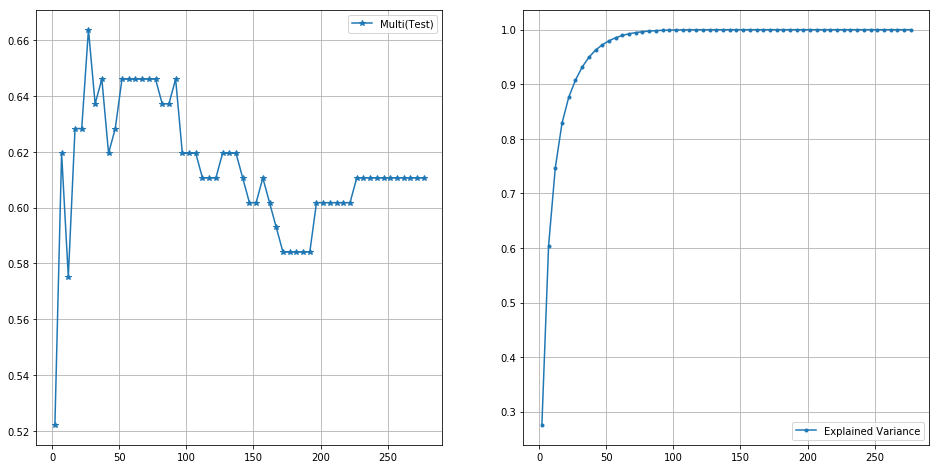

In [427]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot('Principle Components', 'Multi(Test)','*-',data=pca_number)
ax[0].grid(True)
ax[0].legend()

ax[1].plot('Principle Components', 'Explained Variance','.-',data=pca_number)
ax[1].grid(True)
ax[1].legend()

In [429]:
pca=PCA(n_components=37)
pca.fit(Xtrain_mms)
Xtrain_pca=pca.transform(Xtrain_mms)
Xtest_pca=pca.transform(Xtest_mms)
print('The percent of preserving variance is :{:.2f} %'.format(pca.explained_variance_ratio_.sum()*100))

The percent of preserving variance is :82.04 %


In [433]:
#Setting the parameters
aux_linearSVC_pca=SVC()
linearSVCparam_pca={"kernel":["linear"],
               "C":[1,10,100,1000],
               "gamma":[0.01, 0.1, 0.5, 1]}
grid_linearSVC_pca=GridSearchCV(aux_linearSVC_pca, linearSVCparam_pca, cv=5)

#Fitting
grid_linearSVC_pca.fit(Xtrain_pca, y_train)

#Print reports
print("Best K: {}".format(grid_linearSVC_pca.best_params_))
print("Best cross-validation R square: {:.4f}".format(grid_linearSVC_pca.best_score_))
print("Best estimator:\n{}".format(grid_linearSVC_pca.best_estimator_))

Best K: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
Best cross-validation R square: 0.7139
Best estimator:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [434]:
linearSVCmodel_pca=SVC(C=1, gamma=0.01, kernel="linear")
linearSVCmodel_pca.fit(Xtrain_pca, y_train)

ylinearSVC_test_predict_pca=linearSVCmodel_pca.predict(Xtest_pca)

print('Accuracy (training): {:.4f}'.format(linearSVCmodel_pca.score(Xtrain_pca, y_train)))
print('Accuracy (test): {:.4f}'.format(linearSVCmodel_pca.score(Xtest_pca, y_test)))

print(classification_report(y_test, ylinearSVC_test_predict_pca))

Accuracy (training): 0.8230
Accuracy (test): 0.6814
             precision    recall  f1-score   support

          1       0.70      0.92      0.79        61
          2       0.62      0.45      0.53        11
          3       0.80      1.00      0.89         4
          4       0.50      0.75      0.60         4
          5       1.00      0.33      0.50         3
          6       0.00      0.00      0.00         6
         10       0.71      0.42      0.53        12
         16       0.50      0.17      0.25         6
        100       0.67      0.33      0.44         6

avg / total       0.65      0.68      0.64       113



In [430]:
randomforestparam = {"n_estimators":[6, 10, 20, 25, 30, 50],
     "max_depth":[5,10,15,20, None]}
probability_PCA = pd.DataFrame()
for n in y.unique():
    print('Class number: ', n)
    # create y for the class
    y_train_loop = pd.Series([1 if i == n else 0 for i in y_train])
    y_test_loop = pd.Series([1 if i == n else 0 for i in y_test])
    # tuning parameters
    grid_logit=GridSearchCV(RandomForestClassifier(), randomforestparam , scoring = 'roc_auc', cv=3)
    grid_logit.fit(Xtrain_pca, y_train_loop)
    print("Best C: {}".format(grid_logit.best_params_))
    print("Best cross-validation auc_roc: {:.4f}".format(grid_logit.best_score_))
    print('Best estimator:\n{}'.format(grid_logit.best_estimator_))
    best_model = grid_logit.best_estimator_
    best_model.fit(Xtrain_pca, y_train_loop)
    # probability 
    probability_PCA["Topic #%d " % n] = best_model.predict_proba(Xtest_pca)[:,1]

Class number:  100
Best C: {'max_depth': 20, 'n_estimators': 30}
Best cross-validation auc_roc: 0.8026
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Class number:  6
Best C: {'max_depth': 5, 'n_estimators': 25}
Best cross-validation auc_roc: 0.6749
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_s

In [431]:
probability_PCA['ranking'] = probability_PCA.idxmax(axis=1)
probability_PCA['true'] = list(y_test)
probability_PCA['ranking_2'] = probability_PCA['ranking'].map(lambda x:pd.to_numeric(x.split('#')[-1].rstrip()))

In [432]:
print(classification_report(probability['true'], probability['ranking_2']))
print("Accuracy: {:.4f}".format(accuracy_score(probability['true'], probability['ranking_2'])))

             precision    recall  f1-score   support

          1       0.69      0.93      0.79        61
          2       0.38      0.27      0.32        11
          3       0.67      1.00      0.80         4
          4       1.00      0.75      0.86         4
          5       0.50      0.33      0.40         3
          6       0.00      0.00      0.00         6
         10       0.71      0.42      0.53        12
         16       0.00      0.00      0.00         6
        100       0.75      0.50      0.60         6

avg / total       0.60      0.67      0.62       113

Accuracy: 0.6726


In [435]:
parameters = {"C":[0.001, 0.01, 0.1,0.5, 1,5]}
probability_lg = pd.DataFrame()
for n in y.unique():
    print('Class number: ', n)
    # create y for the class
    y_train_loop = pd.Series([1 if i == n else 0 for i in y_train])
    y_test_loop = pd.Series([1 if i == n else 0 for i in y_test])
    # tuning parameters
    grid_logit=GridSearchCV(LogisticRegression(), parameters , scoring = 'roc_auc', cv=3)
    grid_logit.fit(Xtrain_pca, y_train_loop)
    print("Best C: {}".format(grid_logit.best_params_))
    print("Best cross-validation auc_roc: {:.4f}".format(grid_logit.best_score_))
    print('Best estimator:\n{}'.format(grid_logit.best_estimator_))
    best_model = grid_logit.best_estimator_
    best_model.fit(Xtrain_pca, y_train_loop)
    # probability 
    probability_lg["Topic #%d " % n] = best_model.predict_proba(Xtest_pca)[:,1]

Class number:  100
Best C: {'C': 0.1}
Best cross-validation auc_roc: 0.7067
Best estimator:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Class number:  6
Best C: {'C': 5}
Best cross-validation auc_roc: 0.7471
Best estimator:
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Class number:  10
Best C: {'C': 0.5}
Best cross-validation auc_roc: 0.9446
Best estimator:
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver=

In [436]:
probability_lg['ranking'] = probability_lg.idxmax(axis=1)
probability_lg['true'] = list(y_test)
probability_lg['ranking_2'] = probability_lg['ranking'].map(lambda x:pd.to_numeric(x.split('#')[-1].rstrip()))

In [437]:
print(classification_report(probability_lg['true'], probability_lg['ranking_2']))
print("Accuracy: {:.4f}".format(accuracy_score(probability_lg['true'], probability_lg['ranking_2'])))

             precision    recall  f1-score   support

          1       0.71      0.93      0.81        61
          2       0.33      0.09      0.14        11
          3       0.80      1.00      0.89         4
          4       0.75      0.75      0.75         4
          5       1.00      0.33      0.50         3
          6       0.50      0.17      0.25         6
         10       0.75      0.50      0.60        12
         16       0.22      0.33      0.27         6
        100       1.00      0.17      0.29         6

avg / total       0.67      0.67      0.63       113

Accuracy: 0.6726
